测试样本扰动前的预测值：4


<ipython-input-7-506c6f0cd165>:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var_sample = Variable(torch.tensor(new_sample), requires_grad=True)


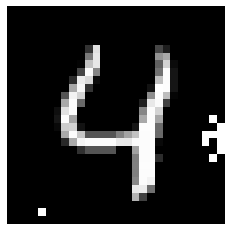

测试样本扰动后的预测值：2
测试样本扰动前的预测值：4
测试样本扰动前的预测值：4
测试样本扰动前的预测值：4
测试样本扰动前的预测值：4
测试样本扰动前的预测值：4
测试样本扰动前的预测值：4
测试样本扰动前的预测值：4
测试样本扰动前的预测值：4
测试样本扰动前的预测值：4
测试样本扰动前的预测值：4


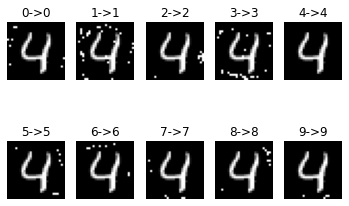

<Figure size 432x288 with 0 Axes>

In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt


# 网络架构
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 计算雅可比矩阵，即前向导数
def compute_jacobian(model, input):

    var_input = input.clone()
    var_input.detach_()
    var_input.requires_grad = True
    output = model(var_input)

    num_features = int(np.prod(var_input.shape[1:]))
    jacobian = torch.zeros([output.size()[1], num_features])
    for i in range(output.size()[1]):
        # zero_gradients(input)
        if var_input.grad is not None:
            var_input.grad.zero_()
        # output.backward(mask,retain_graph=True)
        output[0][i].backward(retain_graph=True)
        # copy the derivative to the target place
        jacobian[i] = var_input.grad.squeeze().view(-1, num_features).clone()

    return jacobian


# 计算显著图
def saliency_map(jacobian, target_index, increasing, search_space, nb_features):


    domain = torch.eq(search_space, 1).float()  # The search domain
    # the sum of all features' derivative with respect to each class
    all_sum = torch.sum(jacobian, dim=0, keepdim=True)
    target_grad = jacobian[target_index]  # The forward derivative of the target class
    others_grad = all_sum - target_grad  # The sum of forward derivative of other classes

    # this list blanks out those that are not in the search domain
    if increasing:
        increase_coef = 2 * (torch.eq(domain, 0)).float()
    else:
        increase_coef = -1 * 2 * (torch.eq(domain, 0)).float()
    increase_coef = increase_coef.view(-1, nb_features)

    # calculate sum of target forward derivative of any 2 features.
    target_tmp = target_grad.clone()
    target_tmp -= increase_coef * torch.max(torch.abs(target_grad))
    alpha = target_tmp.view(-1, 1, nb_features) + target_tmp.view(-1, nb_features, 1)  # PyTorch will automatically extend the dimensions
    # calculate sum of other forward derivative of any 2 features.
    others_tmp = others_grad.clone()
    others_tmp += increase_coef * torch.max(torch.abs(others_grad))
    beta = others_tmp.view(-1, 1, nb_features) + others_tmp.view(-1, nb_features, 1)

    # zero out the situation where a feature sums with itself
    tmp = np.ones((nb_features, nb_features), int)
    np.fill_diagonal(tmp, 0)
    zero_diagonal = torch.from_numpy(tmp).byte()

    # According to the definition of saliency map in the paper (formulas 8 and 9),
    # those elements in the saliency map that doesn't satisfy the requirement will be blanked out.
    if increasing:
        mask1 = torch.gt(alpha, 0.0)
        mask2 = torch.lt(beta, 0.0)
    else:
        mask1 = torch.lt(alpha, 0.0)
        mask2 = torch.gt(beta, 0.0)
    # apply the mask to the saliency map
    mask = torch.mul(torch.mul(mask1, mask2), zero_diagonal.view_as(mask1))
    # do the multiplication according to formula 10 in the paper
    saliency_map = torch.mul(torch.mul(alpha, torch.abs(beta)), mask.float())
    # get the most significant two pixels
    max_value, max_idx = torch.max(saliency_map.view(-1, nb_features * nb_features), dim=1)
    p = max_idx // nb_features
    q = max_idx % nb_features
    return p, q


def perturbation_single(image, ys_target, theta, gamma, model):

    copy_sample = np.copy(image)
    var_sample =Variable(torch.from_numpy(copy_sample), requires_grad=True)

    outputs = model(var_sample)
    predicted = torch.max(outputs.data, 1)[1]
    print('测试样本扰动前的预测值：{}'.format(predicted[0]))

    var_target = Variable(torch.LongTensor([ys_target,]))

    if theta > 0:
        increasing = True
    else:
        increasing = False

    num_features = int(np.prod(copy_sample.shape[1:]))
    shape = var_sample.size()

    # perturb two pixels in one iteration, thus max_iters is divided by 2.0
    max_iters = int(np.ceil(num_features * gamma / 2.0))

    # masked search domain, if the pixel has already reached the top or bottom, we don't bother to modify it.
    if increasing:
        search_domain = torch.lt(var_sample, 0.99) #逐元素比较var_sample和0.99
    else:
        search_domain = torch.gt(var_sample, 0.01)
    search_domain = search_domain.view(num_features)

    model.eval()
    output = model(var_sample)
    current = torch.max(output.data, 1)[1].numpy()

    iter = 0
    while (iter < max_iters) and (current[0] != ys_target) and (search_domain.sum() != 0):
        # calculate Jacobian matrix of forward derivative
        jacobian = compute_jacobian(model, var_sample)
        # get the saliency map and calculate the two pixels that have the greatest influence
        p1, p2 = saliency_map(jacobian, var_target, increasing, search_domain, num_features)
        # apply modifications
        var_sample_flatten = var_sample.view(-1, num_features)
        
        ttt = var_sample_flatten.clone()
        
        #print(var_sample_flatten.shape )
        ttt[0,p1] = var_sample_flatten[0, p1] +theta
        ttt[0,p2] =  var_sample_flatten[0, p2]+theta
        

        new_sample = torch.clamp(ttt, min=0.0, max=1.0)
        new_sample = new_sample.view(shape)
        search_domain[p1] = 0
        search_domain[p2] = 0
        var_sample = Variable(torch.tensor(new_sample), requires_grad=True)

        output = model(var_sample)
        current = torch.max(output.data, 1)[1].cpu().numpy()
        iter += 1

    adv_samples = var_sample.data.cpu().numpy()
    return adv_samples



if __name__=="__main__":

    # 定义数据转换格式
    mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x : x.resize_(28*28))])

    # 导入数据，定义数据接口
    testdata  = torchvision.datasets.MNIST(root="./mnist", train=False, download=True, transform=mnist_transform)
    testloader = torch.utils.data.DataLoader(testdata, batch_size=256, shuffle=True, num_workers=0)
    net = torch.load("demo.pth") # 加载模型
    index = 4 # 选择测试样本
    image = testdata[index][0].resize_(1,784).numpy() # 测试样本特征
    label = torch.tensor([testdata[index][1]]) # 测试样本真实标签

    theta = 1.0 # 扰动值
    gamma = 0.1 # 最多扰动特征数占总特征数量的比例
    ys_target= 2 # 对抗性样本的标签

    # 生成对抗性样本
    adv_image = perturbation_single(image, ys_target, theta, gamma, net)

    # 绘制对抗性样本的图像
    im = adv_image.reshape(28, 28)
    fig = plt.figure()
    plotwindow = fig.add_subplot(111)
    plt.axis('off')
    plt.imshow(im, cmap='gray')
    plt.show()
    plt.close()

    # 模型对对抗性样本的预测结果
    adv_image = Variable(torch.from_numpy(adv_image.reshape(1, 784)), requires_grad=True)
    outputs = net(adv_image)
    predicted = torch.max(outputs.data, 1)[1]
    print('测试样本扰动后的预测值：{}'.format(predicted[0]))

#plt.figure()
for i in range(10):
    adv_image = perturbation_single(image, i, theta, gamma, net)
    adv_image_t = Variable(torch.from_numpy(adv_image.reshape(1, 784)), requires_grad=True)
    outputs = net(adv_image_t)
    predicted = torch.max(outputs.data, 1)[1].item()
    im = adv_image.reshape(28, 28)
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.title(str(i)+"->"+str(predicted))
    plt.imshow(im, cmap='gray')
plt.show()
plt.savefig("test.png")